In [15]:
import tensorflow as tf
import kagglehub
import pandas as pd
kagglehub.login()
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

filename = 'IMDB Dataset.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DJ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Path to dataset files: C:\Users\DJ\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1


In [2]:
df = pd.read_csv(path + '\\' + filename)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
def preprocess_text(text):
    text = text.str.lower() #convert to lowercase
    text = text.str.replace(r'<[^>]+>', '', regex=True) # remove HTML tags
    text = text.str.replace(r'http\S+ | www\S+', '', regex=True) # Remove links
    text = text.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True) #remove nonalphanumeric characters and punctuation
    tokens = text.apply(word_tokenize)
    english_stopwords = stopwords.words('english')
    
    text.apply(lambda x: [t for t in tokens if t not in english_stopwords]) #remove stopwords

    lemmatizer = WordNetLemmatizer()
    def lemmatize_text(text):
        return [lemmatizer.lemmatize(token) for token in text]
    text.apply(lemmatize_text) #lemmatize text
    return text

In [7]:
df = df.apply(preprocess_text)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [8]:
for sentence in df['review'].head(100):
    words = sentence.split()
    print(len(words))


301
156
162
129
222
119
150
170
124
31
88
176
390
107
50
140
146
210
128
131
297
172
65
313
148
107
558
141
122
605
389
337
102
641
253
361
95
299
115
259
119
208
173
255
176
229
76
143
684
93
410
611
158
80
190
201
204
164
480
433
171
143
76
47
178
282
328
143
199
288
221
276
235
188
265
150
297
604
137
288
160
147
251
420
73
147
289
138
187
346
165
182
387
173
137
255
182
126
183
517


In [16]:
# tokenize and pad the reviews for RNN processing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(sequences, 1024) #1000 would capture most of the reviews for padding, 1024 for power of 2

In [17]:
# change positive/negative to 1/0 for easier processing in RNN
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# split data for train/test from tensorflow. X = word reviews and Y = 1/0 for positive/negative review.
X = padded_sequences
y = df['sentiment'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80% training data, 20% test data.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 128), #recommended embedding dimension size is 100 to 300 for NLP
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) #embedding layer, two LSTM layers, and a dense layers for NLP. 2-3 LSTM layers recommended for this type of problem.

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# early stopping callback. used to automatically determine a good number of epochs for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train,
                    epochs=150,
                    batch_size=5,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=0)

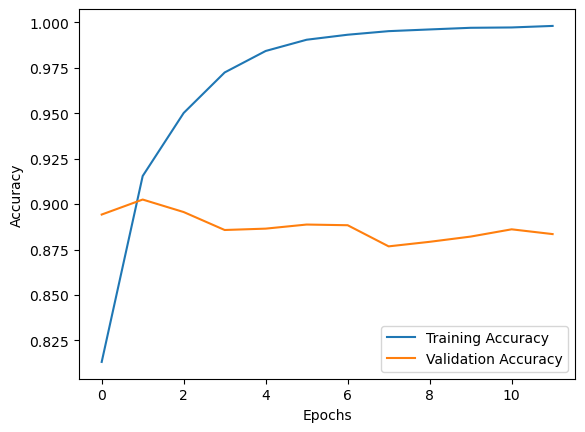

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.2f}")
print(f'Test Accuracy: {test_accuracy:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.9098 - loss: 0.2375
Test Loss: 0.24
Test Accuracy: 0.91


In [25]:
sample_reviews = [
    "This movie was great! The plot was thrilling and kept me engaged the entire time.",
    "The film was terrible, I don't even know what happened after two hours",
    "It wasn't bad but definitely not great. There were some good scenes but it dragged on pretty long. Overall a 4/10.",
    "The movie was pretty decent. I liked the ending."
]

sample_sequences = tokenizer.texts_to_sequences(sample_reviews)
sample_padded = pad_sequences(sample_sequences, 1024)

predictions = model.predict(sample_padded)
print(["Positive" if prob > 0.5 else "Negative" for prob in predictions])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
['Positive', 'Negative', 'Negative', 'Positive']
